In [ ]:
!pip install -q -U transformers==4.37.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0
!pip install -q neo4j networkx plotly graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.5/293.5 kB 1.1 MB/s eta 0:00:00


In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [ ]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

In [ ]:
import requests
from PIL import Image

def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


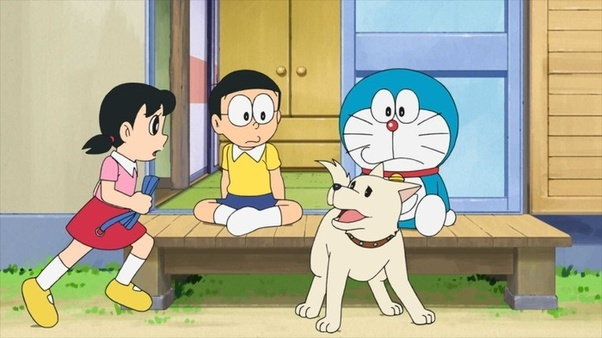

In [98]:
image = load_image("/content/main-qimg-3e322664e5ce050f57e1c7714e0f399f.jpg")
image

In [99]:
max_new_tokens = 200
prompt = "USER: <image>\nDescribe the image to me.\nASSISTANT:"
result_list=[]

for i in range(1):
  outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

  response_text = outputs[0]['generated_text']
  assistant_prefix = "ASSISTANT:"
  response = response_text.split(assistant_prefix, 1)[-1].strip() if assistant_prefix in response_text else response_text
    # Split the text by \n and .
  segments = response.split('.')
  lines = [segment.split('\n') for segment in segments]

  # Flatten the list of lists into a single list
  print(lines)

  for texts in lines:
    if texts[0] !='':
     sentence=texts[0]
     result_list.append(sentence)

  #response = [item.strip() for sublist in lines for item in sublist if item.strip()]

[['The image features a group of people, including a boy and a girl, sitting on a bench'], [' They are accompanied by a white dog, which is sitting on the ground in front of them'], [" The scene appears to be a casual gathering, with the people and the dog enjoying each other's company"], ['']]


In [100]:
result_list

['The image features a group of people, including a boy and a girl, sitting on a bench',
 ' They are accompanied by a white dog, which is sitting on the ground in front of them',
 " The scene appears to be a casual gathering, with the people and the dog enjoying each other's company"]

#Convert the result to dataframe

In [101]:
import pandas as pd
import numpy as np

df=pd.DataFrame({"text":result_list})
df

,text
0,"The image features a group of people, includin..."
1,"They are accompanied by a white dog, which is..."
2,"The scene appears to be a casual gathering, w..."


# Once we get the image description we need to extract triplets

## Loading REBEL model for relation extraction

In [102]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
from tqdm import tqdm
import torch
#from pyvis.network import Network

# Loading REBEL-Large

In [113]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")
gen_kwargs = {
    "max_length": 512,
    "length_penalty": 0,
    "num_beams": 3,
    "num_return_sequences": 3,
}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


#Relation extraction Triplets using REBEL-Large

In [114]:
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets


# Extraction of Triplets

In [115]:
df['text']

0    The image features a group of people, includin...
1     They are accompanied by a white dog, which is...
2     The scene appears to be a casual gathering, w...
Name: text, dtype: object

In [116]:
triplet_list=[]
for i in range(len(df)):
  text=df['text'][i]
  model_inputs= tokenizer(text, max_length= 256, padding=True, truncation=True, return_tensors = 'pt')

  generated_tokens= model.generate(
      model_inputs["input_ids"].to(model.device),
      attention_mask=model_inputs["attention_mask"].to(model.device),
      **gen_kwargs,
  )

  decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)
  # Extract triplets
  for _, sentence in enumerate(decoded_preds):
      triplet_list.append(extract_triplets(sentence))

triplet_list

[[{'head': 'boy', 'type': 'sibling', 'tail': 'girl'},
  {'head': 'girl', 'type': 'sibling', 'tail': 'boy'}],
 [{'head': 'boy', 'type': 'sibling', 'tail': 'girl'}],
 [{'head': 'girl', 'type': 'follows', 'tail': 'boy'}],
 [{'head': 'White Dog', 'type': 'instance of', 'tail': 'dog'}],
 [{'head': 'White', 'type': 'subclass of', 'tail': 'dog'}],
 [{'head': 'White dog', 'type': 'instance of', 'tail': 'dog'}],
 [{'head': 'George Orwell',
   'type': 'notable work',
   'tail': 'Nineteen Eighty-Four'},
  {'head': 'Nineteen Eighty-Four', 'type': 'author', 'tail': 'Orwell'}],
 [{'head': 'George Orwell', 'type': 'notable work', 'tail': 'Animal Farm'},
  {'head': 'Animal Farm', 'type': 'author', 'tail': 'George Orwell'}],
 [{'head': 'George Orwell',
   'type': 'notable work',
   'tail': 'Nineteen Eighty-Four'},
  {'head': 'Nineteen Eighty-Four', 'type': 'author', 'tail': 'George Orwell'}]]

In [117]:
triplet_list = [item for sublist in triplet_list for item in sublist]

In [118]:
df_rebel=pd.DataFrame({'triplet':triplet_list})

In [119]:
df_rebel

,triplet
0,"{'head': 'boy', 'type': 'sibling', 'tail': 'gi..."
1,"{'head': 'girl', 'type': 'sibling', 'tail': 'b..."
2,"{'head': 'boy', 'type': 'sibling', 'tail': 'gi..."
3,"{'head': 'girl', 'type': 'follows', 'tail': 'b..."
4,"{'head': 'White Dog', 'type': 'instance of', '..."
5,"{'head': 'White', 'type': 'subclass of', 'tail..."
6,"{'head': 'White dog', 'type': 'instance of', '..."
7,"{'head': 'George Orwell', 'type': 'notable wor..."
8,"{'head': 'Nineteen Eighty-Four', 'type': 'auth..."
9,"{'head': 'George Orwell', 'type': 'notable wor..."


In [120]:
triplets=df_rebel['triplet'].to_list()

# After Triplet, using NetworkX

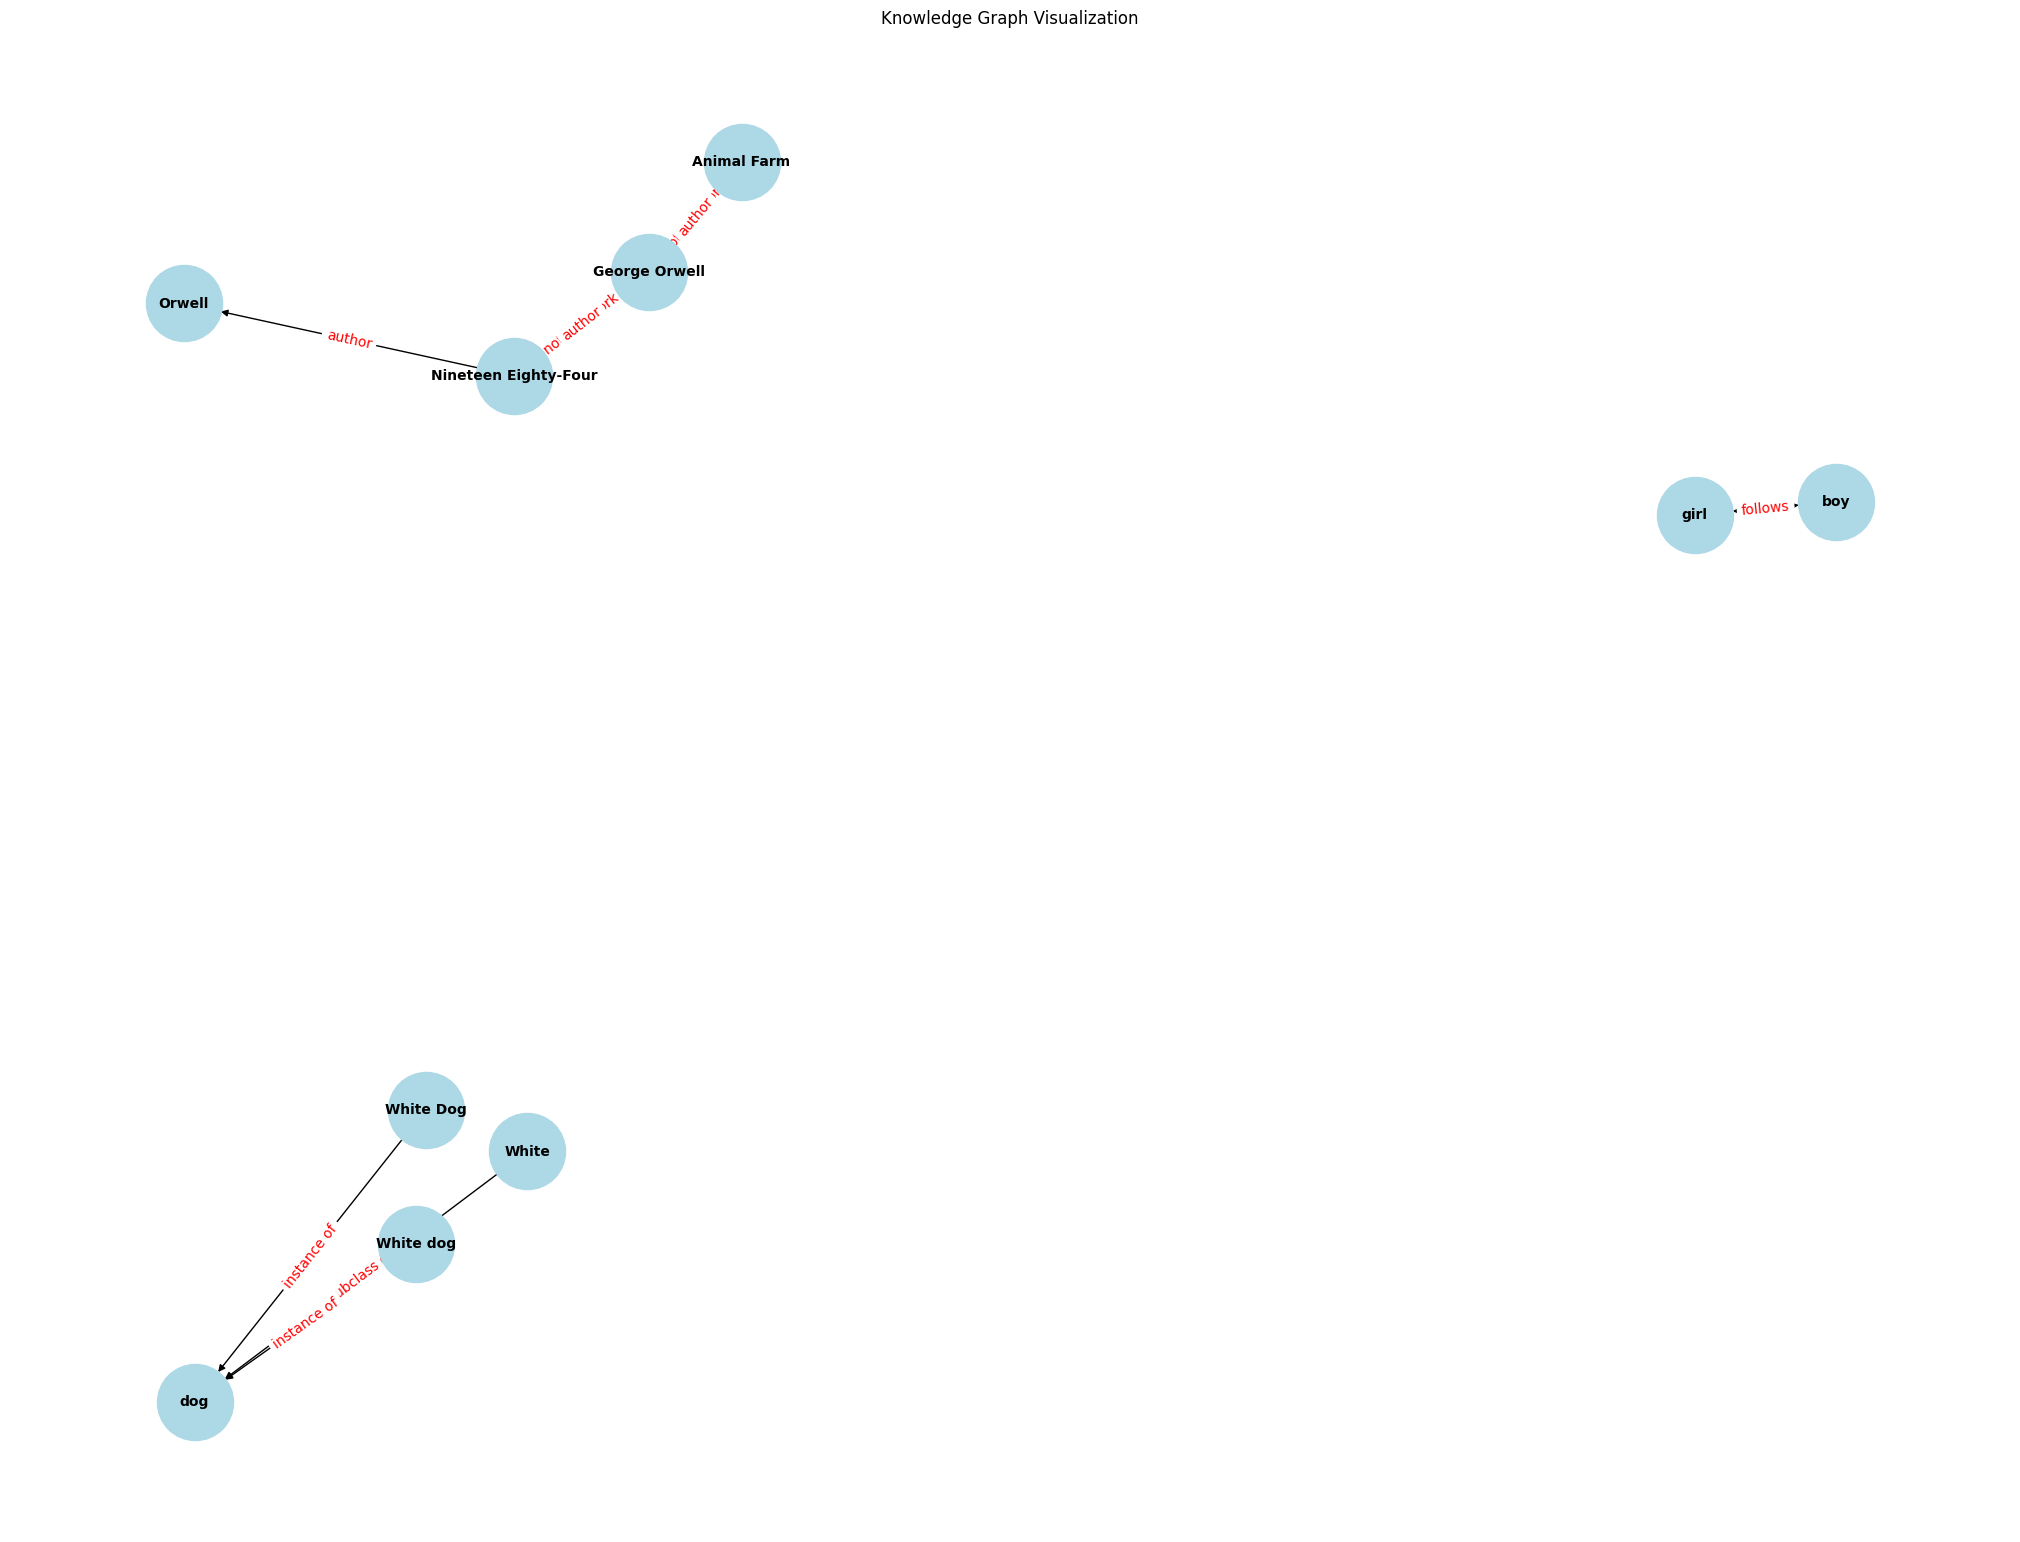

In [121]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()

# Add edges to the graph
for row in triplets:
    if isinstance(row, dict):  # Ensure the item is a dictionary
        G.add_edge(row['head'], row['tail'], label=row['type'])
# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(20, 15))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

plt.title('Knowledge Graph Visualization')
plt.show()